# Installing packages and assigning directory

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import random
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from glob import glob
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from torch.nn.modules.pooling import MaxPool2d
import torch.optim as optim
from torchvision import models
import wandb

In [2]:
# API = 887362a2ceb2116d60b2d826763161b8361e55a1

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: na21b051 (na21b051-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
train_path = '/Users/rawclaymore/Downloads/inaturalist_12K/train'
test_path = '/Users/rawclaymore/Downloads/inaturalist_12K/val'

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Metal GPU
elif torch.cuda.is_available():
    device = torch.device("cuda:0")  # NVIDIA GPU
else:
    device = torch.device("cpu")  # Fallback to CPU

print(f"Using device: {device}")

Using device: mps


In [7]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


# Preprocessing dataset

In [8]:
# Image transforms
train_transforms = transforms.Compose([
    # transforms.RandomRotation(30),
    # transforms.RandomResizedCrop(224),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
train_data = ImageFolder(train_path, transform=train_transforms)
train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
# Set a seed value for reproducibility
torch.manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
test_dataset = ImageFolder(test_path, transform=test_transforms)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [12]:
dataset = DataLoader(train_dataset, shuffle=True, num_workers = 2)
dataiter = iter(dataset)
images, labels = next(dataiter)

In [13]:
print(images.shape)
image_dim = images.shape[2]

torch.Size([1, 3, 224, 224])


## Creating val set with equal images from each class

In [14]:
# Load the dataset
dataset = ImageFolder(train_path, transform=train_transforms)

#Create a dictionary to store the indices of each class
class_indices = {}
for i, (image, label) in enumerate(dataset):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(i)

# Split each class into training and validation sets
train_indices = []
val_indices = []
for indices in class_indices.values():
    random.shuffle(indices)
    split = int(0.8 * len(indices))
    train_indices += indices[:split]
    val_indices += indices[split:]

# Create subsets for the training and validation sets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
len(train_dataset)

7999

In [16]:
# # Create train and validation data loaders
# test_dataset = ImageFolder(test_path, transform=test_transforms)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
# test_dataset.size

In [18]:
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

In [19]:
# print(images.shape)
# print(images[20].shape)
# print(labels[20].item())

#Data visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


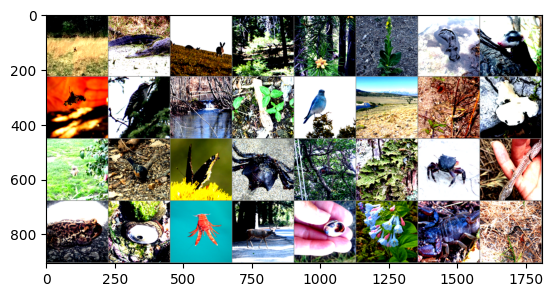

tensor([6, 9, 6, 6, 8, 8, 7, 6, 2, 3, 6, 8, 3, 6, 0, 4, 6, 3, 5, 1, 6, 4, 1, 9,
        0, 7, 1, 6, 7, 8, 2, 9])


In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Getting a batch of images from the train loader
dataiter = iter(train_loader)
images_train, labels_train = next(dataiter)

# Get a batch of images from the test loader
dataiter = iter(test_loader)
images_test, labels_test = next(dataiter)

# Show a few images from the batch
imshow(torchvision.utils.make_grid(images_train))
print(labels_train)

# Resnet

In [21]:
resnet = models.resnet50(pretrained = True)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
for param in resnet.parameters():
    param.requires_grad = False

In [24]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 10)

In [25]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 2048])
torch.Size([10])


In [26]:
resnet = resnet.to(device)
loss_function = nn.CrossEntropyLoss()
la = optim.SGD(resnet.parameters(), lr=0.01)

In [27]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers = 2)

In [28]:
def accuracy(dataloader):
  total, correct_predictions = 0, 0
  for data in dataloader:
    X, Y = data
    X, Y = X.to(device), Y.to(device)
    Y_pred = resnet(X)
    _, pred = torch.max(Y_pred.data, 1)
    total += Y.size(0)
    correct_predictions += (pred == Y).sum().item()
    accuracy = (correct_predictions/total)*100
  return accuracy

In [29]:
# loss_batch = []
# loss_epoch = []
# epochs = 5
# wandb.init(project = 'DA6401_Assignment_2B')

# for epoch in tqdm(range(epochs)):
#   for i, data in enumerate(train_loader, 0):
#       images, labels = data
#       images, labels = images.to(device), labels.to(device)

#       la.zero_grad()
#       y_pred = resnet(images)

#       loss = loss_function(y_pred, labels)
#       loss.backward()
#       la.step()

#       loss_batch.append(loss.item())
#   loss_epoch.append(loss.item())
#   accuracy_val = accuracy(val_loader)
#   accuracy_train = accuracy(train_loader)
#   print('Epoch: %d/%d, Validation acc: %0.2f, Train acc: %0.2f' % (epoch, accuracy_val, accuracy_train ))
#   #wandb.log({'loss_epoch': loss_epoch, 'accuracy_val':accuracy_val, 'accuracy_training':accuracy_training, 'epoch':epoch})
# plt.plot(loss_epoch)
# plt.show()

In [30]:
class CNN(nn.Module):
  def __init__(self, architecture, batch_norm, num_layers, num_filters, conv_filter_size, dropout, activation, dense_neurons):
    super(CNN, self).__init__()
    
    self.layers = []
    self.architecture = architecture
    self.batch_norm = batch_norm
    self.num_conv_layers = num_layers
    self.num_filters = num_filters
    self.conv_filter_size = conv_filter_size
    self.dropout = dropout
    self.dense_neurons = dense_neurons
    self.input_filters = 3
    self.maxpool_filter_size = 2

    if activation == 'ReLU':
      self.activation = nn.ReLU
    if activation == 'GELU':
      self.activation = nn.GELU
    if activation == "SiLU":
      self.activation = nn.SiLU
    if activation == "Mish":
      self.activation = nn.Mish
    if activation == 'LeakyReLU':
      self.activation = nn.LeakyReLU
    if activation == 'ELU':
      self.activation = nn.ELU

    if self.batch_norm == 'YES':
      if self.architecture == 'DOUBLE':
        self.num_filters = 8
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(nn.BatchNorm2d(self.num_filters))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          self.num_filters = self.num_filters*2
        
      if self.architecture == 'HALF':
        self.num_filters = 128
        for i in range(self.num_conv_layers):
          print(i)
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(nn.BatchNorm2d(self.num_filters))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          print('input_filters', self.input_filters)
          self.num_filters = int(self.num_filters/2)
          print('number of filters', self.num_filters)
      
      if self.architecture == 'EQUAL':
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(nn.BatchNorm2d(self.num_filters))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters

    if self.batch_norm == 'NO':
      if self.architecture == 'DOUBLE':
        self.num_filters = 8
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          self.num_filters = self.num_filters*2
        
      if self.architecture == 'HALF':
        self.num_filters = 128
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          self.num_filters = self.num_filters/0.5
      
      if self.architecture == 'EQUAL':
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters

   # Construct sequential module
    self.cnn_model = nn.Sequential()
    for i, layer in enumerate(self.layers):
      self.cnn_model.add_module(str(i), layer)
  
    output_dim = self.compute_output_dim(self.num_conv_layers, self.conv_filter_size, self.maxpool_filter_size)
    input_dense = (output_dim**2)*self.input_filters

    self.fc_model = nn.Sequential(
        nn.Linear(input_dense, self.dense_neurons),
        self.activation(),
        nn.Linear(self.dense_neurons,10)
    )
  
  def compute_output_dim(self, num_conv_layers, conv_filter_size, maxpool_filter_size):
    input_size = image_dim
    for i in range (num_conv_layers):
      conv_output_dim = (input_size - conv_filter_size) + 1
      maxpool_output_dim = np.floor((conv_output_dim - maxpool_filter_size)/2) + 1
      input_size = maxpool_output_dim
    return int(maxpool_output_dim)

  def forward(self, x):
    x = self.cnn_model(x)
    x = x.view(x.size(0), -1)
    print(x.shape)
    x = self.fc_model(x)
    return(x)
     

# WANDB

In [31]:
sweep_configuration = {
  'method': 'grid',
  'name': 'sweep',
  'metric': {'goal': 'maximize', 'name': 'accuracy_val'},
  'parameters': {
      'batch_norm':{'values':['YES','NO']},
      'num_layers': {'values': [5]},
      'num_filters': {'values': [32]},
      'conv_filter_size': {'values': [5]},
      'dropout': {'values': [0.05,0.1,0.2]},
      'activation':{'values':['ReLU', 'GELU', 'LeakyReLU', 'SiLU', 'Mish']},
      'dense_neurons': {'values': [128]},
      'learning_rate': {'values': [1e-4,1e-5,1e-6]},
      'weight_decay': {'values': [0, 0.0005, 0.5]},
      'optimizer': {'values': ['Adam', 'NAdam','RAdam', 'AdamW', 'SGD']},
    } }

In [ ]:
print(device)
def wandbsweeps():
  wandb.init(project = 'DA6401_Assignment_2B')
  print('wandb initialize')
  wandb.run.name = (
        "bn"
        + str(wandb.config.batch_norm)
        + "nf"
        + str(wandb.config.num_filters)
        + "fs"
        + str(wandb.config.conv_filter_size)
        + "do"
        + str(wandb.config.dropout)
        + "lr"
        + str(wandb.config.learning_rate)
        + "opt"
        + wandb.config.optimizer
        + "af"
        + str(wandb.config.activation)
    )
  print('wandb run initialize')
  model = CNN(
    architecture = 'DOUBLE',
    batch_norm = wandb.config.batch_norm,
    num_layers = wandb.config.num_layers,
    num_filters = wandb.config.num_filters,
    conv_filter_size = wandb.config.conv_filter_size,
    dropout = wandb.config.dropout,
    activation = wandb.config.activation,
    dense_neurons = wandb.config.dense_neurons).to(device)
  print('model')

  def accuracy(dataloader):
    total, correct_predictions = 0, 0
    for data in dataloader:
        X, Y = data
        X, Y = X.to(device), Y.to(device)
        Y_pred = model(X)
        _, pred = torch.max(Y_pred.data, 1)
        total += Y.size(0)
        correct_predictions += (pred == Y).sum().item()
        accuracy = (correct_predictions/total)*100
    return accuracy

  ## Loss and optimizer ##
  loss_cr = nn.CrossEntropyLoss()
  print('Loss')
  if wandb.config.optimizer == 'Adam':
    la = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'NAdam':
    la = optim.NAdam(model.parameters(), lr=wandb.config.learning_rate, weight_decay= wandb.config.weight_decay)
  elif wandb.config.optimizer == 'RAdam':
    la = optim.RAdam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'AdamW':
    la = optim.AdamW(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'SGD':
    la = optim.SGD(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  else:
      raise ValueError("Invalid optimizer type.")

  print('optim')
  loss_batch = []
  loss_epoch = []
  epochs = 5
  for i in tqdm(range(epochs)):
    epoch = i+1
    for j, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # print(images.size)
        la.zero_grad()
        y_pred = model(images)
        loss = loss_cr(y_pred, labels)
        loss.backward()
        la.step()
        loss_batch.append(loss.item())
    loss_epoch.append(loss.item())
    accuracy_val = accuracy(val_loader)
    accuracy_train = accuracy(train_loader)
    print('training loop')
    print('Epoch: %d/%d, Validation acc: %0.2f, Train acc: %0.2f' % (epoch, epochs,accuracy_val, accuracy_train ))
    wandb.log({'loss_epoch': loss_epoch, 'accuracy_val':accuracy_val, 'accuracy_training':accuracy_train, 'epoch':epoch})

sweep_id = wandb.sweep(sweep= sweep_configuration, project = 'DA6401_Assignment_2B')
wandb.agent(sweep_id, function = wandbsweeps)
# wandb.agent(sweep_id, function = wandbsweeps, count = 10)

mps
Create sweep with ID: jw0lj93l
Sweep URL: https://wandb.ai/na21b051-indian-institute-of-technology-madras/DA6401_Assignment_2B/sweeps/jw0lj93l


wandb: Agent Starting Run: j6fj9273 with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: YES
wandb: 	conv_filter_size: 5
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.05
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: 32
wandb: 	num_layers: 5
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


wandb initialize
wandb run initialize
model
Loss
optim


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128, 1152])
torch.Size([128,

wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x1696a20d0>> (for post_run_cell), with arguments args (<ExecutionResult object at 16c961750, execution_count=32 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 177eb2c50, raw_cell="print(device)
def wandbsweeps():
  wandb.init(proj.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/rawclaymore/Desktop/DA.ipynb#X51sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

: 